# Continuous Control

---
### Start a new Environment

Before running this cell please make sure you have installed `unityagents` and the `Reacher Environment` is placed in your project folder. For further instructions please follow the the **Getting Started** section in this [README](https://github.com/danatt/drlnd-ContinuousControl/blob/master/README.md) and change the *file_name* variable to match the location of the Unity environment that you downloaded.

In [1]:
from unityagents import UnityEnvironment
import numpy as np

# start a new environment
env = UnityEnvironment(file_name="Reacher_Windows_x86_64/Reacher.exe")

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726671e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


Episode 50	Average Score: 1.20
Episode 100	Average Score: 2.42
Episode 150	Average Score: 6.64
Episode 200	Average Score: 12.88
Episode 250	Average Score: 23.05
Episode 300	Average Score: 32.55
Episode 350	Average Score: 33.88
Episode 400	Average Score: 32.05
Episode 450	Average Score: 32.19
Episode 500	Average Score: 32.13


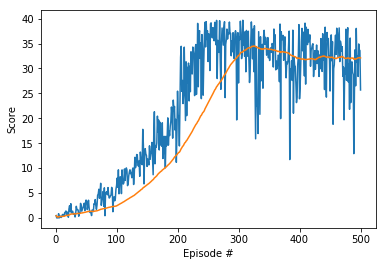

In [2]:
%reload_ext autoreload
%autoreload 2

import gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from ddpg_agent import Agent

agent = Agent(state_size=state_size, action_size=action_size, random_seed=42)


def ddpg(n_episodes=500, print_every=50):
    """Learning by "Deep Deterministic Policy Gradient" - Method (DDPG)
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        print_every (int): print score every 'print_every' episodes
    """    
    
    scores_window = deque(maxlen=100)                      # save last 100 total scores in one episode
    all_scores = []
    avg_scores_window = []
    noise_damp = 0                                         # damping OU-Noise the closer it gets to global max
    max_score = 0                                          # save best score in that run
    
    for i_episode in range(1, n_episodes+1):

        env_info = env.reset(train_mode=True)[brain_name]  # reset the environment
        states = env_info.vector_observations              # get the current state
        
        agent.reset()                                      # reset the agent                                     
        scores = np.zeros(num_agents)                      # initialize the score

        while True:
            actions = agent.act(states, noise_damp)        # select an action from one agent
            env_info = env.step(actions)[brain_name]       # perform the action
            
            next_states = env_info.vector_observations          # get next state
            rewards = env_info.rewards                          # get reward
            dones = env_info.local_done                         # check done
            
            agent.step(states, actions, rewards, next_states, dones, num_updates=1) # agent step

            states = next_states
            scores += rewards

            if np.any(dones):
                break 
        
        # score for one episode of mean of all agents
        avg_score = np.mean(scores)
        
        # save last 100 avg_score scores
        scores_window.append(avg_score)
        
        all_scores.append(avg_score)
        avg_scores_window.append(np.mean(scores_window))
        noise_damp = np.mean(scores_window)
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        
        # save agent if 100 perfomance is better, that max_score
        if max_score < np.mean(scores_window):
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
        max_score = np.mean(scores_window)
        
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))

    return all_scores, avg_scores_window



all_scores, avg_scores_window = ddpg()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(all_scores)+1), all_scores)
plt.plot(np.arange(1, len(avg_scores_window)+1), avg_scores_window)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [3]:
env.close()